# Visa Preprocessing

In [23]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Ingestion

In [24]:
def load_data(url):
    init_data = pd.read_csv(url, sep = ",")
    data = init_data.copy()
    return data

In [25]:
df = load_data("Clean_Visa_data.csv")
df_processed = df.copy()

In [26]:
df_processed.head(1)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied


## 2. Missing values and Duplicate chec

In [27]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum()>0:
        print(missing_values[missing_values>0])
    else:
        print("No missing values as expected from EDA")

def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates>0:
        print(f"Percentage of duplicates: {(duplicates/len(duplicates))*100:.2f}%")
    else:
        print("There are no duplicates as expected from EDA")

In [28]:
check_missing_values(df_processed)
check_duplicates(df_processed)

No missing values as expected from EDA
There are no duplicates as expected from EDA


In [29]:
df_processed.head(2)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified


### Correlation

## Feature Engineering

Features to be engineered
Annual wage, need training_has experiece, need training_hasno experience, wage vs region,

In [30]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [31]:
def feature_engineering(df_processed):
    # Age of establishment
    current_year = datetime.now().year
    df_processed["Age_of_estab"] = current_year - df_processed["yr_of_estab"]

    #Prevailing wage columns
    df_processed["unit_of_wage"] = df_processed["unit_of_wage"].str.strip()
    wage_unit={
        "Hour": 2080, #8 hours against 52 weeks
        "Week": 52,
        "Month": 12,
        "Year": 1
    }

    df_processed["annual_wages"] = df_processed["prevailing_wage"]* df_processed['unit_of_wage'].map(wage_unit)
    df_processed["monthly_wages"] = df_processed["annual_wages"]/12
    df_processed["weekly_wages"] = df_processed["annual_wages"]/52
    df_processed["hourly_wages"] = df_processed["annual_wages"]/2080

    

In [32]:
feature_engineering(df_processed)

In [33]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wages,monthly_wages,weekly_wages,hourly_wages
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,102648.502667,23688.116000,592.202900
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,6952.137500,1604.339423,40.108486
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,10249.738333,2365.324231,59.133106
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,6952.835833,1604.500577,40.112514
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,12492.282500,2882.834423,72.070861


## 2. Outlier Detection and Handling

### Outlier Detection

In [34]:
def categorical_numerical(df):
    num_col = df.select_dtypes(include=["number"]).columns
    cat_col = df.select_dtypes(include=["object"]).columns
    cat_col = cat_col.drop('case_id') #considering dropping soon

    return num_col, cat_col

In [35]:
numerical_features, categorical_features = categorical_numerical(df_processed)

In [36]:
numerical_features

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'Age_of_estab',
       'annual_wages', 'monthly_wages', 'weekly_wages', 'hourly_wages'],
      dtype='object')

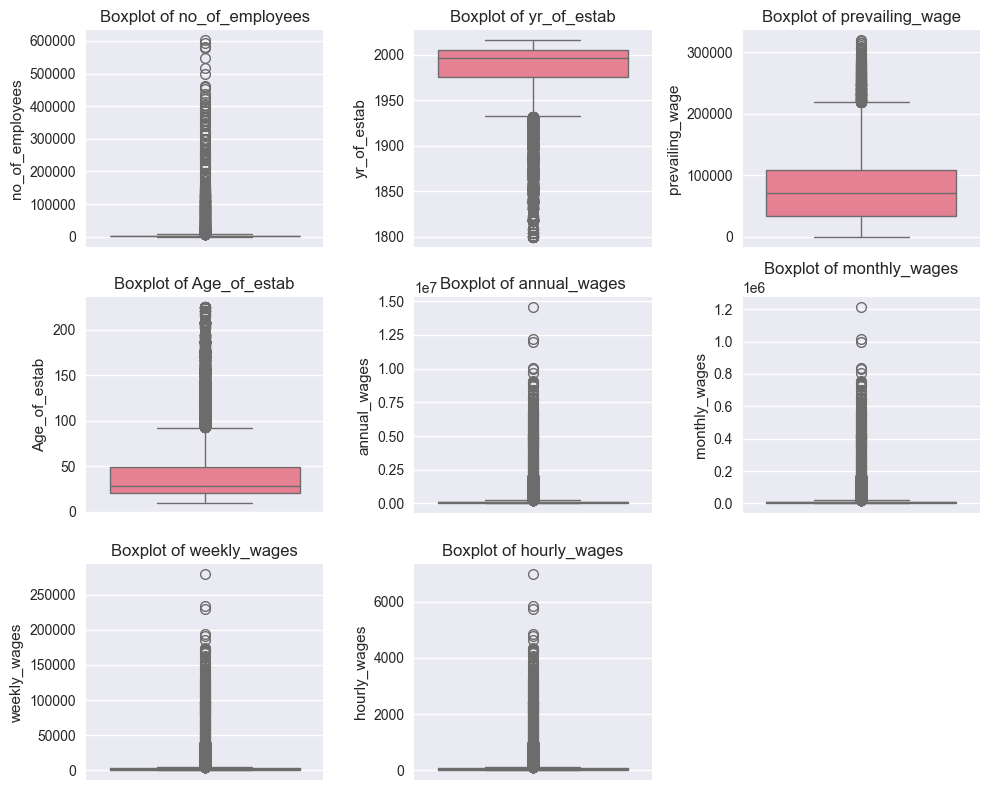

In [37]:
plt.figure(figsize=(10,8))

for i, variable in enumerate(numerical_features):
    plt.subplot(3,3, i+1)
    sns.boxplot(data=df_processed, y=variable)
    plt.title(f"Boxplot of {variable}")
    plt.tight_layout()
plt.show()

### Outlier Handling

In [38]:
def cap_outlier(df, columns):
    
    outliers_capped = 0
    for col in columns:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_before = ((df_processed[col]< lower_bound)| (df[col] > upper_bound)).sum()
        if outliers_before > 0:
            df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
            df_processed[col] = np.where(df_processed[col]> upper_bound, upper_bound, df_processed[col])
            outliers_capped += outliers_before
            print(f"\n{col}: Capped {outliers_before} outliers")

    
    print(f'\nTotal outliers capped: {outliers_capped}')
    print(f"Dataset shape after outlier treatment: {df_processed.shape}")

In [39]:
cap_outlier(df_processed, numerical_features)


no_of_employees: Capped 1556 outliers

yr_of_estab: Capped 3260 outliers

prevailing_wage: Capped 427 outliers

Age_of_estab: Capped 3260 outliers

annual_wages: Capped 2387 outliers

monthly_wages: Capped 2387 outliers

weekly_wages: Capped 2387 outliers

hourly_wages: Capped 2387 outliers

Total outliers capped: 18051
Dataset shape after outlier treatment: (25480, 17)


## 3. Handling Skewness

In [40]:
def handle_skewness(df_processed, column, threshold = 0.5):
    for var in column:
        skewness = df_processed[var].skew()
        if skewness > threshold:
            print(f"\n{var} is right-skewed")
            df_processed[f"{var}_log"] = np.log1p(df_processed[var])

        elif skewness < threshold:
            print(f"\n{var} is left-skewed")
            df_processed[f"{var}_square"] = np.square(df_processed[var])
        else:
            print(f"\n{var} is moderately skewed or moderately symmetric")
        
      

In [41]:
handle_skewness(df_processed, numerical_features)


no_of_employees is right-skewed

yr_of_estab is left-skewed

prevailing_wage is right-skewed

Age_of_estab is right-skewed

annual_wages is right-skewed

monthly_wages is right-skewed

weekly_wages is right-skewed

hourly_wages is right-skewed


## Encoding

In [42]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wages,monthly_wages,weekly_wages,hourly_wages,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wages_log,monthly_wages_log,weekly_wages_log,hourly_wages_log
0,EZYV01,Asia,High School,N,N,7227.0,2007.0,West,592.2029,Hour,Y,Denied,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,Certified,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,Bachelor's,N,Y,7227.0,2008.0,West,122996.8600,Year,Y,Denied,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,Bachelor's,N,N,98.0,1932.5,West,83434.0300,Year,Y,Denied,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,Certified,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [43]:
df_processed["education_of_employee"].unique()

array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object)

In [44]:
df_processed["region_of_employment"].unique()

array(['West', 'Northeast', 'South', 'Midwest', 'Island'], dtype=object)

In [45]:
# edu_order = [["High School", "Bachelor's", "Master's", "Doctorate"]]
def ordinal_encoding(df_processed):
    #Encoding education
    edu_order = [["High School", "Bachelor's", "Master's", "Doctorate"]]
    oe = OrdinalEncoder(categories=edu_order)
    df_processed["education_of_employee"] = oe.fit_transform(df_processed[["education_of_employee"]])

def binary_encoding(df_processed, features):
    le = LabelEncoder()
    for col in features:
        df_processed[col] = le.fit_transform(df_processed[col])

def one_hot_encoding(df_processed, features):
    ohe = OneHotEncoder(sparse_output=False, drop="first")
    # df_processed[features] = ohe.fit_transform(df_processed[[features]])
    encode = ohe.fit_transform(df_processed[features])
    encoded_df = pd.DataFrame(encode, columns=ohe.get_feature_names_out(features), index=df_processed.index)
    df_processed = pd.concat([df_processed.drop(columns=features), encoded_df], axis = 1)

        

In [46]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wages,monthly_wages,weekly_wages,hourly_wages,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wages_log,monthly_wages_log,weekly_wages_log,hourly_wages_log
0,EZYV01,Asia,High School,N,N,7227.0,2007.0,West,592.2029,Hour,Y,Denied,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,Certified,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,Bachelor's,N,Y,7227.0,2008.0,West,122996.8600,Year,Y,Denied,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,Bachelor's,N,N,98.0,1932.5,West,83434.0300,Year,Y,Denied,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,Certified,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [47]:
binary_col = ["has_job_experience", "requires_job_training", "full_time_position", "case_status"]
binary_encoding(df_processed, binary_col)
ordinal_encoding(df_processed)

df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wages,monthly_wages,weekly_wages,hourly_wages,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wages_log,monthly_wages_log,weekly_wages_log,hourly_wages_log
0,EZYV01,Asia,0.0,0,0,7227.0,2007.0,West,592.2029,Hour,1,1,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,2.0,1,0,2412.0,2002.0,Northeast,83425.6500,Year,1,0,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,1.0,0,1,7227.0,2008.0,West,122996.8600,Year,1,1,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,1.0,0,0,98.0,1932.5,West,83434.0300,Year,1,1,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,2.0,1,0,1082.0,2005.0,South,149907.3900,Year,1,0,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [48]:
# exclude = edu_order + binary_col
# multi_encoding = [f for f in categorical_features if not any(f == e for e in exclude)]

# one_hot_encoding(df_processed, multi_encoding)
# df_processed.head()

## Feature Scaling

In [49]:
numerical_features

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'Age_of_estab',
       'annual_wages', 'monthly_wages', 'weekly_wages', 'hourly_wages'],
      dtype='object')

In [50]:
#We do not scale encoded values
scaler = StandardScaler()
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
print(df_processed[numerical_features].std())

no_of_employees    1.00002
yr_of_estab        1.00002
prevailing_wage    1.00002
Age_of_estab       1.00002
annual_wages       1.00002
monthly_wages      1.00002
weekly_wages       1.00002
hourly_wages       1.00002
dtype: float64


## Feature Selection

In [51]:
df_processed.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status', 'Age_of_estab', 'annual_wages',
       'monthly_wages', 'weekly_wages', 'hourly_wages', 'no_of_employees_log',
       'yr_of_estab_square', 'prevailing_wage_log', 'Age_of_estab_log',
       'annual_wages_log', 'monthly_wages_log', 'weekly_wages_log',
       'hourly_wages_log'],
      dtype='object')

In [53]:
X = df_processed.drop(columns=["case_status", "case_id"], axis=1)
y = df_processed["case_status"]

high_features = []

high_plus_engineered = high_features + [col for col in X.columns if any(keyword in col.lower() for keyword in ["log", "square", "wages", "age"])]

selected_features = high_plus_engineered

print(f"Selected features set: {len(selected_features)} features")
print(f"Selected features: {selected_features}")


Selected features set: 15 features
Selected features: ['prevailing_wage', 'unit_of_wage', 'Age_of_estab', 'annual_wages', 'monthly_wages', 'weekly_wages', 'hourly_wages', 'no_of_employees_log', 'yr_of_estab_square', 'prevailing_wage_log', 'Age_of_estab_log', 'annual_wages_log', 'monthly_wages_log', 'weekly_wages_log', 'hourly_wages_log']


## Datat Splitting

In [54]:
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

X_selected = X[selected_features]

#First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y,  test_size=0.2, random_state=42, stratify=y
)

#Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify = y_temp
)
print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f})%")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f})%")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f})%")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())

print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())

print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())

=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution

Data split results:
Training set: (15288, 15) (60.0)%
Validation set: (5096, 15) (20.0)%
Test set: (5096, 15) (20.0)%

Class distribution verification:
Training set quality distribution:
case_status
0    10210
1     5078
Name: count, dtype: int64

Validation set quality distribution:
case_status
0    3404
1    1692
Name: count, dtype: int64

Test set quality distribution:
case_status
0    3404
1    1692
Name: count, dtype: int64


In [55]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(),1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train.columns if any(keyword in col.lower() for keyword in ["log", "square", "wages", "age"])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

#Visualize feature importance
plt.figure(figsize=(12,8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ["total", "ratio", "monthly", "log"])else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel("Absolute Correlation with Quality")
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


=== FEATURE IMPORTANCE ANALYSIS ===


ValueError: could not convert string to float: 'Year'